In [58]:
# Author: Yilin Zheng
# Reference code: https://github.com/myociss/decision_trees
# import necessary library
import pandas as pd
import numpy as np
from math import log
from copy import deepcopy
from random import randint
from IPython.display import display

data = pd.read_table("house-votes-1984.txt",delimiter=",", header=None).dropna()

display(data.head(n=5))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,R,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,R,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,D,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,D,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,D,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [59]:
# ID3 with post pruning
class Node:
    def __init__(self, dataset, feature_index, information_gain_ratio=0.0):
        """
        Node of the tree
        data: the data which best classified by the node
        feature_index: label of the node, which is the index of the feature
        """
        self.positive = None
        self.negative = None
        self.dataset = dataset
        self.feature_index = feature_index
        self.information_gain_ratio = information_gain_ratio

    def add(self, node):
        """
        if label is 'y', we mark as positive otherwise mark negative
        """
        if all(data[0][self.feature_index] == 'y' for data in node.dataset):
            self.positive = node
        else:
            self.negative = node
            
    def set_positive(self, node):
        self.positive = node
        
    def set_negative(self, node):
        self.negative = node
        
class Tree:
    def __init__(self, dataset, features_indice):
        """
        initialization
        train_data: the dataset, every item contains feature value and its label
                    the form is ([features1, feature2, ...], label)
                    index 0 for data, index 1 for label
        features: a list of feature indice, not the name
        """
        self.dataset = dataset
        self.features_indice = features_indice
        self.root = self.build_tree(self.dataset, self.features_indice)
        self.as_list = []    
    
    def entropy(self, sub_dataset):
        """
        compute the entropy
        sub_dataset: sub dataset
        """
        if len(sub_dataset) == 0:
            return 0.0
        else:
            prob_pos = [data[1] for data in sub_dataset].count('D') / len(sub_dataset) # 'D' labelled as postive
            prob_neg = 1 - prob_pos # 'R' labelled as negative, assume dataset has no missing label
            if prob_pos == 0.0 or prob_neg == 0.0:
                return 0.0
            else:
                return - prob_pos * log(prob_pos, 2) - prob_neg * log(prob_neg, 2)
    
    def information_gain(self, sub_dataset, feature_index):
        """
        calculate the information gain
        for data with label 'y',  count as a positive examples, while count as negative examples
        sub_dataset: sub dataset
        feature_index: the index of the feature
        """
        prob_y = [data[0][feature_index] for data in sub_dataset].count('y') / len(sub_dataset)
        prob_n = 1 - prob_y
        y = [data for data in sub_dataset if data[0][feature_index] == 'y']
        n = [data for data in sub_dataset if data[0][feature_index] == 'n']
        return self.entropy(sub_dataset) - prob_y * self.entropy(y) - prob_n * self.entropy(n)

    def select_feature(self, sub_dataset, features_indice):
        """
        select best feature to split data
        features_indice: a list of all features indices
        """
        information_gain_all = {feature_index: self.information_gain(sub_dataset, feature_index) \
                                for feature_index in features_indice}
        max_information_gain = max(information_gain_all, key=information_gain_all.get)
        max_information_gain_ratio = max_information_gain / self.entropy(sub_dataset)
        return max_information_gain, max_information_gain_ratio 
        
    def build_tree(self, sub_dataset, features_indice):
        """
        build the tree
        """
        if len(set([data[1] for data in sub_dataset])) == 1:
            return Node(sub_dataset, set([data[1] for data in sub_dataset]).pop())
        elif len(sub_dataset) == 2:
            return Node(sub_dataset, '+')
        elif sub_dataset:
            best_feature_index, max_information_gain_ratio = self.select_feature(sub_dataset, features_indice)
            new_node = Node(sub_dataset, best_feature_index, max_information_gain_ratio)
            remaining_features_indice = [feature_index for feature_index in features_indice \
                                         if feature_index != best_feature_index]
            for value in ['y', 'n']:
                data_has_feature_value = [data for data in sub_dataset if data[0][best_feature_index] == value]
                new_node.add(self.build_tree(data_has_feature_value, list(remaining_features_indice)))
            return new_node
        else:
            majority = [data[1] for data in sub_dataset]
            return Node(sub_dataset, max(set(majority), key=majority.count))
 
    def accuracy(self, tree, dataset):
        """
        calculate the accuracy of the tree
        """
        classified_data = ['D' if self.classify(tree, data) else 'R' for data in dataset]
        return len([data for classified_label, data in zip(classified_data, dataset) \
                    if classified_label == data[1]]) / len(dataset)
    
    def classify(self, tree, test_data):
        """
        classify data
        tree: the trained tree
        test_data: test dataset
        """
        node = tree.root
        while node.feature_index not in ['D', 'R', '+', '-']:
            if test_data[0][node.feature_index] == 'y':
                  node = node.positive
            else:
                  node = node.negative
        return node.feature_index in ['D', '+']
    
    def to_list(self, node):
        """
        convert the tree to list
        """
        tree_as_list = [node]
        if node.positive != None and node.positive.feature_index not in ['D', 'R', '+', '-']:
            tree_as_list += self.to_list(node.positive)
        if node.negative != None and node.negative.feature_index not in ['D', 'R', '+', '-']:
            tree_as_list += self.to_list(node.negative)
        return tree_as_list
    
    def post_prune(self, l, k, validation_data):
        """
        prune the tree by post pruning
        """
        pruned_tree = deepcopy(self)
        for w in range(1, l):
            prime_tree = deepcopy(self)
            m = randint(2, k)
            for q in range(1, m):
                prime_tree_as_list = self.to_list(prime_tree.root)
                prime_tree_length = len(prime_tree_as_list)
                p = randint(2, prime_tree_length - 1)
                node = prime_tree_as_list[p]
                majority = [data[1] for data in node.dataset]
                node.feature_index = max(set(majority), key=majority.count)
                node.set_positive(None)
                node.set_negative(None)
            if self.accuracy(prime_tree, validation_data) > self.accuracy(pruned_tree, validation_data):
                pruned_tree = deepcopy(prime_tree)
        return pruned_tree    
    
    def print_tree(self, node, depth, limited=None):
        """
        print the tree
        node: the root of the tree or subtree
        depth: depth of the tree or subtree
        limited: limited depth we wan to show
        """
        if limited == None or depth - 1 < limited:
            if node.positive and node.positive.feature_index not in ['D', 'R', '+', '-']:
                print("|" * depth + str(node.feature_index) + " = y :")
                self.print_tree(node.positive, depth + 1, limited)
            elif node.positive:
                print("|" * depth + str(node.feature_index) + " = y :" + str(node.positive.feature_index))
            if node.negative and node.negative.feature_index not in ['D', 'R', '+', '-']:
                print("|" * depth + str(node.feature_index) + " = n :")
                self.print_tree(node.negative, depth + 1, limited)
            elif node.negative:
                print("|" * depth + str(node.feature_index) + " = n :" + str(node.negative.feature_index))
        else:
            pass
    
    
    def feature_importance(self, tree):
        """
        calculate the importance of the features and return the most prominent one
        tree: trained or pruned tree
        """
        most_prominent_feature = None
        largest_information_gain = 0.0
        node_list = self.to_list(tree.root)
        node_feature_index_dict = {node.feature_index: node.information_gain_ratio for node in node_list}
        return max(node_feature_index_dict, key=node_feature_index_dict.get)

In [60]:
# preprocess data

# for missing value, drop the row of the data
data = data[data[:] != '?'].dropna().reset_index(drop=True) # clean data

# labels for all data, a list
parties = [p for p in data[0]]

# drop label, the rest part is all the data without labels
data_final = data.drop(columns=[0]) 

display(len(parties))
display(data_final.head(n=5))

from sklearn.model_selection import train_test_split

def train_and_test(data_final, labels, test_size):
    # shuffle and split data
    X_train, X_test, y_train, y_test = train_test_split(data_final, parties, test_size=test_size, shuffle=True)
    data_train = []
    for point, label in zip(X_train.values, y_train):
        data_train.append((point.tolist(), label))
    data_test = []
    for point, label in zip(X_test.values, y_test):
        data_test.append((point.tolist(), label))
    features_index = [index for index in range(len(data_train[0][0]))]
#     print("train data size: {}".format(len(data_train)))
#     print("test data size: {}".format(len(data_test)))
    tree = Tree(data_train, features_index)
#     print(tree.accuracy(data_test))
    return tree.accuracy(tree, data_test), tree

232

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
2,y,y,y,n,n,n,y,y,y,n,y,n,n,n,y,y
3,y,y,y,n,n,n,y,y,y,n,n,n,n,n,y,y
4,y,n,y,n,n,n,y,y,y,y,n,n,n,n,y,y


In [61]:
# P1
# test and train with different test size
test_size_set = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
accuracy_set = []
for test_size in test_size_set:
    accuracy, tree = train_and_test(data_final, parties, test_size)
    accuracy_set.append(accuracy)
print(accuracy_set)

[0.9166666666666666, 0.9583333333333334, 0.9714285714285714, 0.9361702127659575, 0.9310344827586207, 0.9428571428571428, 0.926829268292683, 0.956989247311828, 0.9428571428571428, 0.9655172413793104, 0.9453125, 0.9428571428571428, 0.9536423841059603, 0.9693251533742331, 0.9597701149425287, 0.9623655913978495, 0.9343434343434344, 0.9665071770334929, 0.8416289592760181]


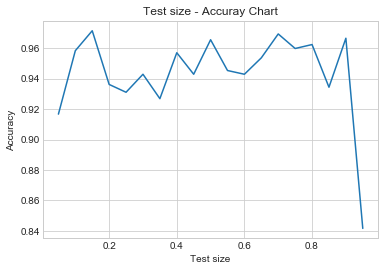

In [62]:
# plot the the figure
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.plot(test_size_set, accuracy_set)
plt.xlabel('Test size') 
plt.ylabel('Accuracy')
plt.title("Test size - Accuray Chart")
plt.show()

In [63]:
# P2
# Calculate the most prominent feature by select the feature which provides the max information gain ratio
accuracy, tree = train_and_test(data_final, parties, 0.2)
feature_index = tree.feature_importance(tree)
print(feature_index)

10


In [66]:
# P3
# Prune the tree by post pruning
accuracy, tree = train_and_test(data_final, parties, 0.2)
print("Before pruning:")
tree.print_tree(tree.root, 0)

X_train, X_test, y_train, y_test = train_test_split(data_final, parties, test_size=0.2, shuffle=True)
data_test = []
for point, label in zip(X_test.values, y_test):
    data_test.append((point.tolist(), label))

print("After pruning:")
tree = tree.post_prune(3, 3, data_test)
tree.print_tree(tree.root, 0)

Before pruning:
3 = y :
|10 = y :
||8 = y :D
||8 = n :
|||15 = y :
||||0 = y :
|||||1 = y :+
|||||1 = n :R
||||0 = n :R
|||15 = n :
||||0 = y :R
||||0 = n :
|||||1 = y :
||||||2 = y :D
||||||2 = n :
|||||||12 = y :R
|||||||12 = n :D
|||||1 = n :D
|10 = n :R
3 = n :
|2 = y :D
|2 = n :
||5 = y :D
||5 = n :
|||14 = y :D
|||14 = n :R
After pruning:
3 = y :
|10 = y :
||8 = y :D
||8 = n :
|||15 = y :
||||0 = y :
|||||1 = y :+
|||||1 = n :R
||||0 = n :R
|||15 = n :
||||0 = y :R
||||0 = n :
|||||1 = y :
||||||2 = y :D
||||||2 = n :
|||||||12 = y :R
|||||||12 = n :D
|||||1 = n :D
|10 = n :R
3 = n :
|2 = y :D
|2 = n :
||5 = y :D
||5 = n :
|||14 = y :D
|||14 = n :R


In [69]:
# P4
# take test size = 0.2 as an example
accuracy, tree = train_and_test(data_final, parties, 0.2)

# depth 1
print("Depth 1:")
tree.print_tree(tree.root, 0, 1)

# depth 2
print("Depth 2:")
tree.print_tree(tree.root, 0, 2)

# depth 3
print("Depth 3:")
tree.print_tree(tree.root, 0, 3)

Depth 1:
3 = y :
|10 = y :
|10 = n :R
3 = n :
|2 = y :D
|2 = n :
Depth 2:
3 = y :
|10 = y :
||8 = y :
||8 = n :
|10 = n :R
3 = n :
|2 = y :D
|2 = n :
||5 = y :D
||5 = n :
Depth 3:
3 = y :
|10 = y :
||8 = y :
|||0 = y :+
|||0 = n :D
||8 = n :
|||9 = y :R
|||9 = n :
|10 = n :R
3 = n :
|2 = y :D
|2 = n :
||5 = y :D
||5 = n :
|||13 = y :R
|||13 = n :D
